# FinanceBot Workflow
The purpose of this file is to ensure that all dependencies are correctly installed.

In [1]:
from _functions import *  # Ensure this function exists

import json
import pandas as pd
import matplotlib.pyplot as plt
import copy
from typing import TypedDict, List
from langchain_openai import ChatOpenAI  # Correct import for ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
import operator
from pydantic import BaseModel
from langchain.schema import HumanMessage

llm = ChatOpenAI(temperature=0.7)

# FinanceBot Workflow
The purpose of this file is to ensure that all dependencies are correctly installed.

## Create State Graph
Create this graph to better keep track the information between states

In [2]:
# Graph State Definition
class State(TypedDict):
    ticker: Annotated[List[str], operator.add]  # Corrected type hint with AnnotatedKey
    data: pd.DataFrame
    arts: pd.DataFrame
    plot: plt.Figure
    response: str
    intro: str
    summary: str

In [3]:
def stock_info_node(state: State) -> State:
    """Fetches a brief company introduction using the ticker."""
    ticker = state.get("ticker", ["GM"])  # Default to GM
    intro = llm.invoke(f"You are to give a brief synopsis of the company associated with the ticker {ticker[0]}. \
                       Use Axios-style bullet points with emojis about key aspects such as the business sector \
                       and some historical information.")
    
    new_state = copy.deepcopy(state)
    new_state['intro'] = intro.content
    return new_state

In [4]:
search_tool = TavilySearchResults()

def search_ticker(state: State) -> State:
    ticker = state["ticker"]
    query = f"Latest financial data and trends for {', '.join(ticker)}"
    search_results = search_tool.run(query)
    return {"response": search_results}

def process_data(state: State) -> State:
    response = state["response"]
    # Assuming we extract structured data from the response
    df = pd.DataFrame([{"Ticker": t, "Data": response} for t in state["ticker"]])
    return {"arts": df}

def generate_insights(state: State) -> State:
    response = state["response"]
    messages = [HumanMessage(content=f"Summarize the following financial data:{response}")]
    summary = llm(messages)
    return {"summary": summary.content}

In [5]:
def stock_data_node(state: State) -> State:
    """Fetches stock data for the given ticker."""
    ticker = state['ticker'][0]  # Default to GM
    stock_data = get_stock_data(ticker=ticker)  # Ensure function exists

    new_state = copy.deepcopy(state)
    new_state['data'] = stock_data  # Avoid unnecessary JSON serialization
    return new_state

In [6]:
def plot_stock_data_node(state: State) -> State:
    """Generates a plot of the stock closing prices over time."""
    df = state['data'].copy()  # Ensure safe copy
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['timestamp'], df['close'], marker='o', linestyle='-')
    ax.set_title('Stock Closing Prices Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.grid(True)

    new_state = copy.deepcopy(state)
    new_state['plot'] = fig
    return new_state

In [7]:
# Initialize LangGraph Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("get_data", stock_data_node)
workflow.add_node("plot_data", plot_stock_data_node)
workflow.add_node("introduction", stock_info_node)

workflow.add_node("search", search_ticker)  # Fixed node reference
workflow.add_node("process", process_data)  # Fixed node reference
workflow.add_node("insight", generate_insights)  # Fixed node reference


workflow.add_edge(START, "get_data")
workflow.add_edge("get_data", "plot_data")
workflow.add_edge("plot_data", END)

workflow.add_edge(START, "search")
workflow.add_edge("search", "process")
workflow.add_edge("process", "insight")
workflow.add_edge("insight", END)


workflow.add_edge(START, "introduction")
workflow.add_edge("introduction", END)

# Ensure the workflow is compiled before invoking
chain = workflow.compile()

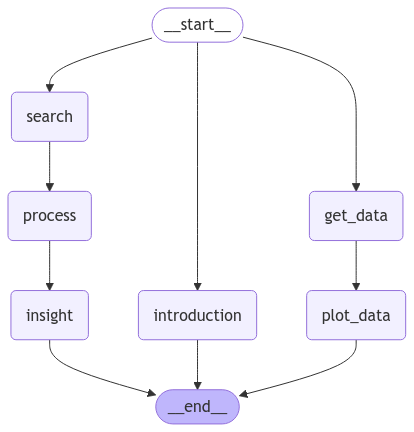

In [8]:
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

C:\Users\Trevo\AppData\Local\Temp\ipykernel_15540\3001074778.py:18: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = llm(messages)


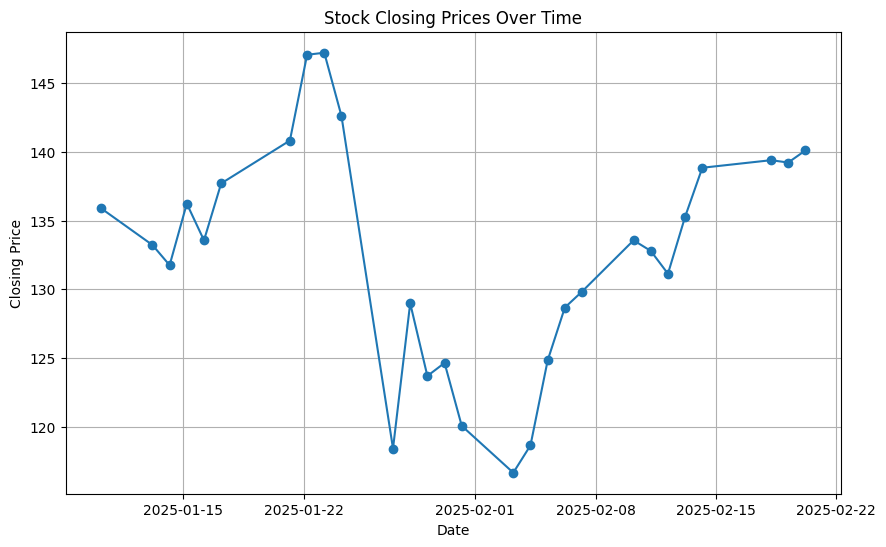

In [9]:
# Ensure the workflow is compiled before invoking
chain = workflow.compile()

# Invoke the workflow with the correct input format
state = chain.invoke({"ticker": ["NVDA"]})

- 🏢 Company: NVIDIA Corporation
- 💼 Sector: Technology - Semiconductors
- 📅 Founded in 1993
- 🌐 Headquarters: Santa Clara, California
- 🚀 Known for its graphics processing units (GPUs) for gaming and professional markets
- 💡 Pioneered the development of GPUs for parallel computing and artificial intelligence
- 📈 Listed on the NASDAQ stock exchange under the ticker symbol NVDA.


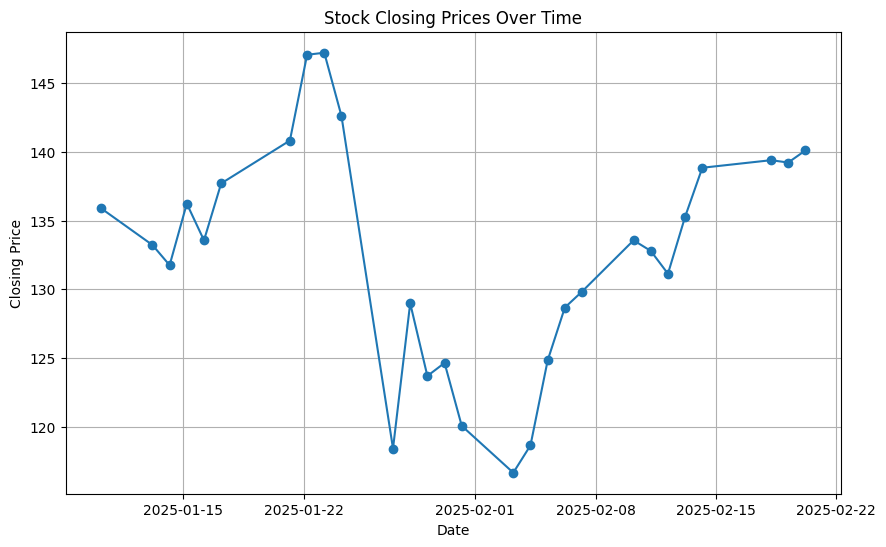

In [12]:
print(state['intro'])
state['plot']

In [13]:
print(state['summary'])

NVIDIA announced record quarterly Data Center revenue of $30.8 billion, up 17% from the previous quarter and 112% from a year ago. The company reported revenue for the third quarter ended October 27, 2024, of $35.1 billion, up 17% from the previous quarter and 94% from a year ago. Wall Street analysts expect NVIDIA to post quarterly earnings of $0.84 per share in its upcoming report, with projected revenue climbing 72% to $20.89 billion. NVIDIA offers GeForce GPUs for gaming and PCs, GeForce NOW game streaming service, Quadro/NVIDIA RTX GPUs for enterprise workstation graphics, and solutions for gaming platforms, among other products and services.
